In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [3]:
class DSO:
	def __init__(self, totalHours, marginalCost, unitSalePrice, maxPriceReference):
		self.totalHours = totalHours
		self.numberOfAggregators = 0
		self.marginalCost = marginalCost
		self.unitSalePrice = unitSalePrice
		self.maxPriceReference = maxPriceReference
		self.aggregators = []
		self.maxUtility = 0
		self.m = 0

	def addAggregator(self, aggregator):
		self.aggregators.append(aggregator)
		self.numberOfAggregators = self.numberOfAggregators + 1

	def getAggregators(self):
		return self.aggregators

	def Sfunction(self, aggregator, tIndex):
		return aggregator.maximumDemand[tIndex] * aggregator.maxPriceReference[tIndex] * (1 - np.exp(-aggregator.preferenceSatisfaction[tIndex] * (aggregator.bestLoadResponse[tIndex] / aggregator.nominalDemand[tIndex])))
	
	def CostFunction(self, aggregator, tIndex):
		return self.marginalCost[tIndex]
	
	def getLeftLimit(self):
		leftLimit = [0 for i in range(self.totalHours)]
		for i in range(self.totalHours):
			mx = 0
			for j in range(self.numberOfAggregators):
				agg = self.aggregators[j]
				mx = max(mx, agg.preferenceSatisfaction[i] * agg.maxPriceReference[i] * np.exp(-agg.preferenceSatisfaction[i] * (agg.maximumDemand[i] / agg.nominalDemand[i])))
			leftLimit[i] = mx
		return leftLimit
	
	def getRightLimit(self):
		rightLimit = [0 for i in range(self.totalHours)]
		for i in range(self.totalHours):
			mx = 0
			for j in range(self.numberOfAggregators):
				agg = self.aggregators[j]
				mx = max(mx, agg.preferenceSatisfaction[i] * agg.maxPriceReference[i] * np.exp(-agg.preferenceSatisfaction[i] * (agg.minimumDemand[i] / agg.nominalDemand[i])))
			rightLimit[i] = mx
		return rightLimit
	
	def getUnitSalePriceRange(self):
		minPrice = self.marginalCost
		leftLimit = self.getLeftLimit()
		minPrice = np.minimum(minPrice, leftLimit)

		maxPrice = self.maxPriceReference
		rightLimit = self.getRightLimit()
		maxPrice = np.maximum(maxPrice, rightLimit)

		return minPrice, maxPrice
	
	def setUnitSalePrice(self, unitSalePrice, tIndex):
		self.unitSalePrice[tIndex] = unitSalePrice

	def generateM(self):
		m = 0
		mx = 0
		for i in range(self.totalHours):
			sum = 0
			for j in range(self.numberOfAggregators):
				agg = self.aggregators[j]
				sum = sum + agg.bestLoadResponse[i]
			mx = max(mx, sum)
		m = random.uniform(mx, mx*10)
		self.m = m

	def utilityFunction(self, m, theta, omega):
		# self.generateUnitSalePrice()
		self.generateM()
		print('m value:', self.m)

		# store value of INT_MIN in mx
		mx = -1000000000000
		for j in range(self.totalHours):
			sum = 0
			for i in range(self.numberOfAggregators):
				agg = self.aggregators[i]
				sum = sum + self.unitSalePrice[j] * agg.bestLoadResponse[j] - self.CostFunction(agg, j) * agg.bestLoadResponse[j] + omega * self.Sfunction(agg, j)
			sum = sum - theta*m
			mx = max(mx, sum)
		return mx
	
	def partialUtilityFunction(self, m, theta, omega, tIndex):
		# store value of INT_MIN in mx
		sum=0 
		for i in range(self.numberOfAggregators):
			agg = self.aggregators[i]
			sum = sum + self.unitSalePrice[tIndex] * agg.bestLoadResponse[tIndex] - self.CostFunction(agg, tIndex) * agg.bestLoadResponse[tIndex] + omega * self.Sfunction(agg, tIndex)
		return sum

			

	def getPAR(self):
		# sum of all bestResponses for each hour for each aggregator
		sum = 0
		for i in range(self.totalHours):
			for j in range(self.numberOfAggregators):
				sum = sum + self.aggregators[j].bestLoadResponse[i]
		return (self.m * self.totalHours) / (sum)

class Aggregator:
	def __init__(self, totalHours, nominalDemand, minimumDemand, maximumDemand, maxPriceReference, preferenceSatisfaction):
		self.totalHours = totalHours
		self.nominalDemand = nominalDemand
		self.minimumDemand = minimumDemand
		self.maximumDemand = maximumDemand
		self.maxPriceReference = maxPriceReference
		self.preferenceSatisfaction = preferenceSatisfaction
		self.currentUtility = 0
		self.bestLoadResponse = [0 for i in range(totalHours)]

	def utilityFunction(self, DSO):
		sum = 0
		for i in range(DSO.totalHours):
			sum = sum + DSO.Sfunction(self, i) - (DSO.unitSalePrice[i] * self.bestLoadResponse[i])
		return sum

	def optimalDR(self, DSO, j):
			return ((self.nominalDemand[j] / self.preferenceSatisfaction[j]) * (np.log((self.preferenceSatisfaction[j] * self.maxPriceReference[j]) / DSO.unitSalePrice[j])))

	def checkConstraints(self, tIndex):
		flag = True
		# print('bestLoadResponse:', self.bestLoadResponse[tIndex])
		# print('minimumDemand:', self.minimumDemand[tIndex])
		# print('maximumDemand:', self.maximumDemand[tIndex])
		if self.bestLoadResponse[tIndex] < self.minimumDemand[tIndex]:
			flag = False
		if self.bestLoadResponse[tIndex] > self.maximumDemand[tIndex]:
			flag = False
		return flag


In [4]:
datasetPath = '../dataset/'

In [5]:
numOfLA = 3
numOfHours = 50

In [6]:
nominalDemands = []
for i in range (0, 3):
	letter = chr(ord('A') + i)
	fileName = 'Home' + letter + '_hourly.csv'
	df = pd.read_csv(datasetPath + fileName)
	df = df[0:numOfHours]
	# Power is in kW
	nominalDemands.append(df['Power'].tolist())

In [7]:
LAs = []
for i in range(numOfLA):
	nominalDemand = nominalDemands[i]
	# find max of nominalDemand
	maxNominalDemand = max(nominalDemand)
	minimumDemand = np.random.uniform(0.0001, nominalDemand, numOfHours)
	maximumDemand = np.random.uniform(nominalDemand, maxNominalDemand+1, numOfHours)
	preferenceSatisfaction = np.random.uniform(0.1, 15, numOfHours)
	maxPriceReference = np.random.randint(1000, 10000000, numOfHours)
	LAs.append(Aggregator(numOfHours, nominalDemand, minimumDemand, maximumDemand, maxPriceReference, preferenceSatisfaction))


In [8]:
# # print all the values for each LA
# for i in range(numOfLA):
# 	print("LA", i)
# 	print("nominal demand: ", LAs[i].nominalDemand)
# 	print("minimum demand: ", LAs[i].minimumDemand)
# 	print("maximum demand: ", LAs[i].maximumDemand)
# 	print("max price reference: ", LAs[i].maxPriceReference)
# 	print("preference satisfaction: ", LAs[i].preferenceSatisfaction)

In [9]:
marginalCost = np.random.randint(1, 7, numOfHours) # cent/kW
unitSalePrice = np.random.randint(1, 7, numOfHours) # cent/kWh
dso = DSO(numOfHours, marginalCost, unitSalePrice, maxPriceReference)

In [10]:
# append all the LAs to the DSO
for i in range(numOfLA):
	dso.addAggregator(LAs[i])

In [11]:
# print all the values for the DSO
# print(dso.getUnitSalePriceRange())

In [12]:
# omega = 5
# theta = 0.01
# minP, maxP = dso.getUnitSalePriceRange()
# list = [ [False for i in range(numOfLA)] for j in range(numOfHours)]
# bigFlag = True
# while bigFlag:
#     for i in range(numOfHours):
#         price = minP[i]
#         maxUT = -1000000000000
#         bestPrice = 0
#         continueFlag = False
#         while price <= maxP[i]:
#             # print("price: ", price)
#             dso.setUnitSalePrice(price, i)
#             flag = [False for i in range(numOfLA)]
#             smallFlag = True
#             for j in range(numOfLA):
#                 actualLoad = LAs[j].optimalDR(dso,i)
#                 LAs[j].bestLoadResponse[i] = actualLoad
#                 list[i][j] = list[i][j] or LAs[j].checkConstraints(i)
#                 smallFlag = smallFlag and LAs[j].checkConstraints(i)
#             if smallFlag == True:
#                 continueFlag = True
#             price += 100
#         if continueFlag == True:
#             continue
#         # check if all values of list are true
#         if  all(item == True for item in list[i]):
#             bigFlag = False
#         for l in range(numOfLA):
#             allOK = True
#             for k in range(numOfHours):
#                 allOK = allOK and list[k][l]
#             if allOK == False:
#                 LAs[l].maxPriceReference[i] = LAs[l].maxPriceReference[i] + 1000
#                 LAs[l].preferenceSatisfaction[i] = LAs[l].preferenceSatisfaction[i] - 0.1
    
# for i in range(numOfHours):
#     price = minP[i]
#     maxUT = -1000000000000
#     bestPrice = 0
#     while price <= maxP[i]:
#         # print("price: ", price)
#         flag = True
#         dso.setUnitSalePrice(price, i)
#         for j in range(numOfLA):
#             actualLoad = LAs[j].optimalDR(dso,i)
#             LAs[j].bestLoadResponse[i] = actualLoad
#             flag = flag and LAs[j].checkConstraints(i)
#         dsoUTILITY = dso.partialUtilityFunction(dso.m, theta, omega, i)
#         if flag == True and dsoUTILITY > maxUT:
#             maxUT = dsoUTILITY
#             bestPrice = price
#         price += 100
#     dso.setUnitSalePrice(bestPrice, i)


# # print(map)
    


In [13]:
omega = 5
theta = 0.01
minP, maxP = dso.getUnitSalePriceRange()
flag1 = True
while flag1:
    noValues = [True for i in range(numOfHours)]
    for i in range(numOfHours):
        flag2 = True
        temp = 0
        while flag2:
            price = minP[i]
            flag3 = [False for i in range(numOfLA)]
            flag4 = [False for i in range(numOfLA)]
            flag5 = [False for i in range(numOfLA)]
            while price <= maxP[i]:
                # print("price: ", price)
                dso.setUnitSalePrice(price, i)
                flag = [False for i in range(numOfLA)]
                for j in range(numOfLA):
                    actualLoad = LAs[j].optimalDR(dso,i)
                    LAs[j].bestLoadResponse[i] = actualLoad
                    flag[j] = LAs[j].checkConstraints(i)
                if flag.count(True) == 3:
                    flag2 = False
                    temp = price
                    noValues[i] = False
                    break
                #if any two values of flag are true and the rest are false
                t1=0
                t2=0
                t3=0
                if flag.count(True) == 2 and flag.count(False) == 1:
                    t1 = price
                    flag3 = flag
                if flag.count(True) == 1 and flag.count(False) == 2:
                    t2 = price
                    flag4 = flag
                if flag.count(True) == 0 and flag.count(False) == 3:
                    t3 = price
                    flag5 = flag
                price += 100
            if t1!=0:
                index = flag3.index(False)
                difference = dso.unitSalePrice[i] - LAs[index].maxPriceReference[i]
                LAs[index].maxPriceReference[i] = dso.unitSalePrice[i] + 100
                LAs[index].preferenceSatisfaction[i] = LAs[index].preferenceSatisfaction[i] * difference/dso.unitSalePrice[i]
                if (LAs[0].checkConstraints(i) and LAs[1].checkConstraints(i) and LAs[2].checkConstraints(i)):
                    flag2 = False
                    temp = price
                    noValues[i] = False
                    break
            elif t2!=0:
                #do the same as above but for both the LAs with false values
                index1 = flag4.index(False)
                index2 = flag4.index(False, index1+1)
                difference1 = dso.unitSalePrice[i] - LAs[index1].maxPriceReference[i]
                difference2 = dso.unitSalePrice[i] - LAs[index2].maxPriceReference[i]
                LAs[index1].maxPriceReference[i] = dso.unitSalePrice[i] + 100
                LAs[index1].preferenceSatisfaction[i] = LAs[index1].preferenceSatisfaction[i] * difference1/dso.unitSalePrice[i]
                LAs[index2].maxPriceReference[i] = dso.unitSalePrice[i] + 100
                LAs[index2].preferenceSatisfaction[i] = LAs[index2].preferenceSatisfaction[i] * difference2/dso.unitSalePrice[i]
                if (LAs[0].checkConstraints(i) and LAs[1].checkConstraints(i) and LAs[2].checkConstraints(i)):
                    flag2 = False
                    temp = price
                    noValues[i] = False
                    break
            elif t3!=0:
                #do the same as above but for all the LAs
                for j in range(numOfLA):
                    difference = dso.unitSalePrice[i] - LAs[j].maxPriceReference[i]
                    LAs[j].maxPriceReference[i] = dso.unitSalePrice[i] + 100
                    LAs[j].preferenceSatisfaction[i] = LAs[j].preferenceSatisfaction[i] * difference/dso.unitSalePrice[i]
                if (LAs[0].checkConstraints(i) and LAs[1].checkConstraints(i) and LAs[2].checkConstraints(i)):
                    flag2 = False
                    temp = price
                    noValues[i] = False
                    break
        dso.setUnitSalePrice(temp, i)
    if all(item == False for item in noValues):
        flag1 = False

                # price += 100
        # if flag == False:
        #     noValues[i] = False
    # if all(item == True for item in noValues):
    #     flag1 = False
    # for l in range(numOfLA):


C:\Users\venkat\AppData\Local\Temp\ipykernel_19992\3805270669.py:123: RuntimeWarning: invalid value encountered in log
  return ((self.nominalDemand[j] / self.preferenceSatisfaction[j]) * (np.log((self.preferenceSatisfaction[j] * self.maxPriceReference[j]) / DSO.unitSalePrice[j])))
C:\Users\venkat\AppData\Local\Temp\ipykernel_19992\3805270669.py:123: RuntimeWarning: divide by zero encountered in double_scalars
  return ((self.nominalDemand[j] / self.preferenceSatisfaction[j]) * (np.log((self.preferenceSatisfaction[j] * self.maxPriceReference[j]) / DSO.unitSalePrice[j])))


In [14]:
# # save the variables for each LA
# for i in range(numOfLA):
# 	letter = chr(ord('A') + i)
# 	fileName = 'Home' + letter + '_hourly.csv'
# 	df = pd.read_csv(datasetPath + fileName)
# 	df = df[0:numOfHours]
# 	df['nominalDemand'] = LAs[i].nominalDemand
# 	df['minimumDemand'] = LAs[i].minimumDemand
# 	df['maximumDemand'] = LAs[i].maximumDemand
# 	df['preferenceSatisfaction'] = LAs[i].preferenceSatisfaction
# 	df['bestLoadResponse'] = LAs[i].bestLoadResponse
# 	df.to_csv(datasetPath + 'Home' + letter + '_hourly_extended_results.csv', index=False)

In [15]:
# # save the variables for the DSO
# df = pd.DataFrame()
# df['marginalCost'] = dso.marginalCost
# df['unitSalePrice'] = dso.unitSalePrice
# df['PAR'] = dso.getPAR()
# df.to_csv(datasetPath + 'DSO_hourly_results_extended.csv', index=False)

In [16]:
# print Unit Sale Price
print("Unit Sale Price: ", dso.unitSalePrice)

Unit Sale Price:  [   1205   27605    2005   71906    3803  483702  466305     604  896505
    1904  323104    3502 2009604       2   93106     105   31502    7202
   24503   79706     205   35301    2603     104     100     104    2104
     101     104     306  101406     204     104     100     205       5
    1702  564506   21604    1505    1706     305   10003    1104     405
  422303     100 1934301     100    1403]


In [17]:
# DSO gives the price for each hour & each LA calculates the optimal DR
for i in range(numOfLA):
	# la = LAs[i]
	for j in range(numOfHours):
		# la.optimalDR(dso, j)
		LAs[i].optimalDR(dso, j)

C:\Users\venkat\AppData\Local\Temp\ipykernel_19992\3805270669.py:123: RuntimeWarning: invalid value encountered in log
  return ((self.nominalDemand[j] / self.preferenceSatisfaction[j]) * (np.log((self.preferenceSatisfaction[j] * self.maxPriceReference[j]) / DSO.unitSalePrice[j])))


In [18]:
# print best load response for each LA
for i in range(numOfLA): # kWh
	print("LA", i)
	print("best load response: ", dso.aggregators[i].bestLoadResponse)

LA 0
best load response:  [0.18751095112346786, 0.500616007575591, 1.4724185747412775, nan, 0.5910708464457521, 0.29438540103050503, 1.53005394353567, 0.7875712199328411, 1.0964890896299804, 0.4882369857424195, nan, 0.7042549344737945, 0.0886475920288989, 0.7202353208008254, 1.4414794693570323, nan, 0.3641686002821723, 0.611539795345487, 1.4860126270073222, 1.1387446341545326, 0.8447253937205241, 1.093769384173205, 0.27758135132081874, 0.4198584194158394, 0.9105344694054732, 0.3934246369042059, 1.1609711522388553, 0.9732237318290053, 0.3496948031803127, nan, 0.8973243737474818, 0.3778971374997778, 1.553839971257907, 0.9490597877922854, 0.5610613242093964, nan, 0.4467838097932816, 1.4886541675273683, 0.49494114199127043, 0.9770519645011089, 1.7810039675871194, 0.7404900075110151, 0.4852913819786432, 0.5194465182811774, 1.530159238667843, nan, 0.5949316361430783, 0.11862342607810863, 0.4430348771625584, 0.5308554010696327]
LA 1
best load response:  [0.9163289112940147, 2.68132325591237, 

In [19]:
# # check for negative values in each LA best load response
# for i in range(numOfLA):
# 	la = dso.aggregators[i]
# 	for j in range(numOfHours):
# 		if la.bestLoadResponse[j] < 0:
# 			print("LA", i, "best load response for hour", j, "is negative")

omega : weight factor for customer satisfaction

theta : weight factor for peak demand

m : peak demand > max of sum of load at all times

In [20]:
# DSO takes back the load response from each aggregator
m = np.random.randint(1, 100)
omega = 5
theta = 0.01

dso.maxUtility = dso.utilityFunction(m, theta, omega)
dso.maxUtility

m value: 32.00038139477984


C:\Users\venkat\AppData\Local\Temp\ipykernel_19992\3805270669.py:20: RuntimeWarning: overflow encountered in exp
  return aggregator.maximumDemand[tIndex] * aggregator.maxPriceReference[tIndex] * (1 - np.exp(-aggregator.preferenceSatisfaction[tIndex] * (aggregator.bestLoadResponse[tIndex] / aggregator.nominalDemand[tIndex])))


-281572237.91801643

In [21]:
# DSO takes back the load response from each aggregator
m = np.random.randint(1, 100)
omega = 6
theta = 0.02

dso.maxUtility = dso.utilityFunction(m, theta, omega)
dso.maxUtility

m value: 122.66187697763414


C:\Users\venkat\AppData\Local\Temp\ipykernel_19992\3805270669.py:20: RuntimeWarning: overflow encountered in exp
  return aggregator.maximumDemand[tIndex] * aggregator.maxPriceReference[tIndex] * (1 - np.exp(-aggregator.preferenceSatisfaction[tIndex] * (aggregator.bestLoadResponse[tIndex] / aggregator.nominalDemand[tIndex])))


-338837171.89725286

In [22]:
# DSO takes back the load response from each aggregator
m = np.random.randint(1, 100)
omega = 2
theta = 0.1

dso.maxUtility = dso.utilityFunction(m, theta, omega)
dso.maxUtility

m value: 68.5107546531655


C:\Users\venkat\AppData\Local\Temp\ipykernel_19992\3805270669.py:20: RuntimeWarning: overflow encountered in exp
  return aggregator.maximumDemand[tIndex] * aggregator.maxPriceReference[tIndex] * (1 - np.exp(-aggregator.preferenceSatisfaction[tIndex] * (aggregator.bestLoadResponse[tIndex] / aggregator.nominalDemand[tIndex])))


-109777445.44030729

In [23]:
# print utility for each house
for i in range(numOfLA):
	print("LA", i)
	ut = LAs[i].utilityFunction(dso)
	print("utility: ", ut)

LA 0
utility:  nan
LA 1
utility:  nan
LA 2
utility:  nan


C:\Users\venkat\AppData\Local\Temp\ipykernel_19992\3805270669.py:20: RuntimeWarning: overflow encountered in exp
  return aggregator.maximumDemand[tIndex] * aggregator.maxPriceReference[tIndex] * (1 - np.exp(-aggregator.preferenceSatisfaction[tIndex] * (aggregator.bestLoadResponse[tIndex] / aggregator.nominalDemand[tIndex])))


In [24]:
dso.getPAR()

nan

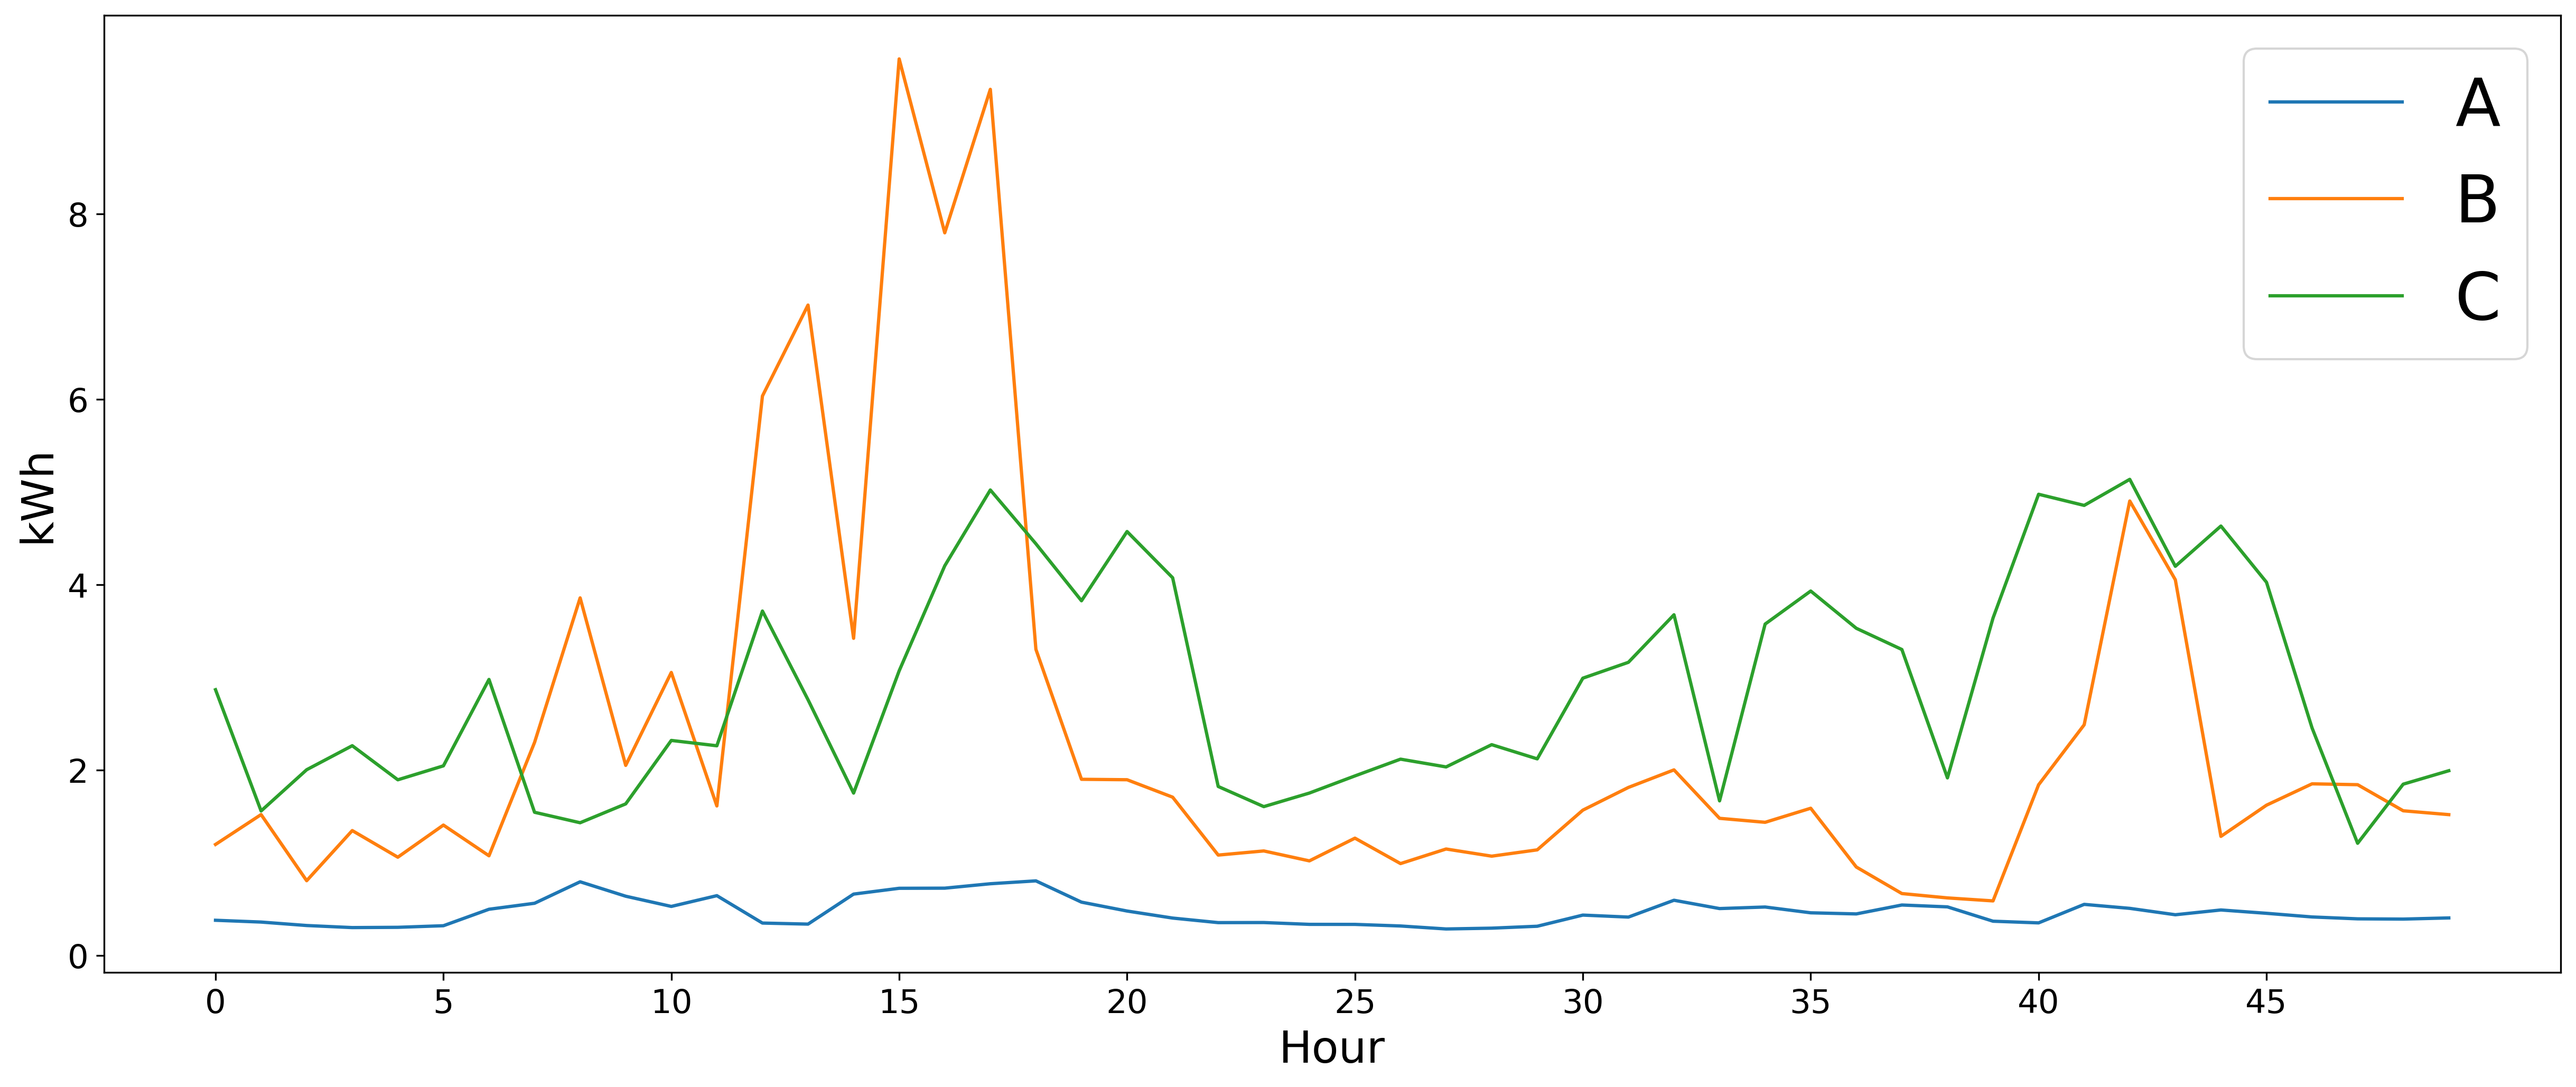

In [42]:
# plot nominal demand of each LA
plt.figure(figsize=(20,8), dpi=300)
plt.xlabel('Hour', fontsize=20)
plt.ylabel('kWh', fontsize=20)
plt.xticks(np.arange(0, numOfHours, 5), fontsize=15)
plt.yticks(np.arange(0, 10, 2), fontsize=15)
for i in range(numOfLA):
	plt.plot(LAs[i].nominalDemand)
plt.legend([chr(ord('A') + i) for i in range(numOfLA)], fontsize=30)
plt.show()

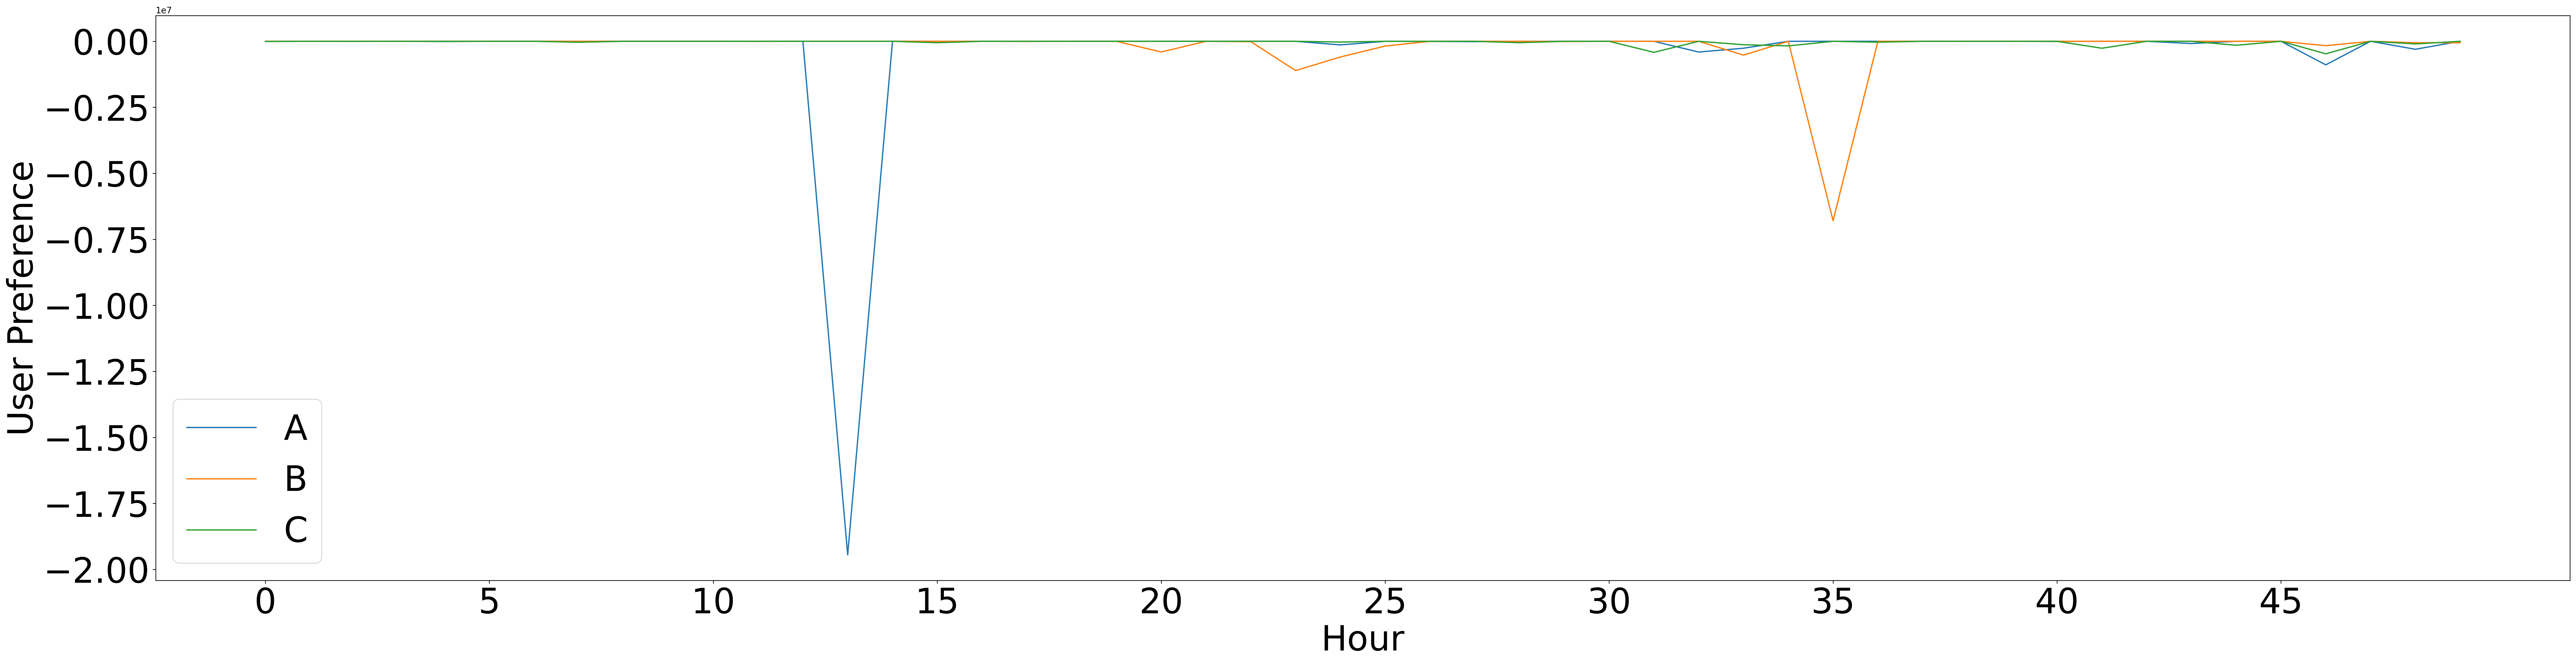

In [47]:
# plot user pref of each LA
plt.figure(figsize=(50, 12), dpi=300)
plt.xticks(np.arange(0, numOfHours, 5), fontsize=40)
plt.yticks(fontsize=40)
plt.xlabel('Hour', fontsize=40)
plt.ylabel('User Preference', fontsize=40)
for i in range(numOfLA):
	plt.plot(LAs[i].preferenceSatisfaction)
plt.legend([chr(ord('A') + i) for i in range(numOfLA)], fontsize=40)
plt.show()

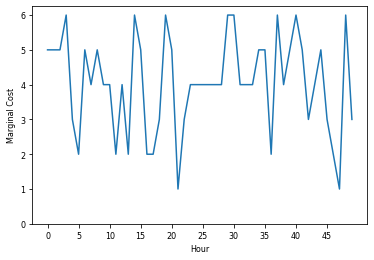

In [36]:
# plot marginal cost
plt.plot(dso.marginalCost)
plt.xticks(np.arange(0, numOfHours, 5), fontsize=8)
plt.yticks(np.arange(0, 7, 1), fontsize=8)
plt.xlabel('Hour', fontsize=8)
plt.ylabel('Marginal Cost', fontsize=8)
plt.show()

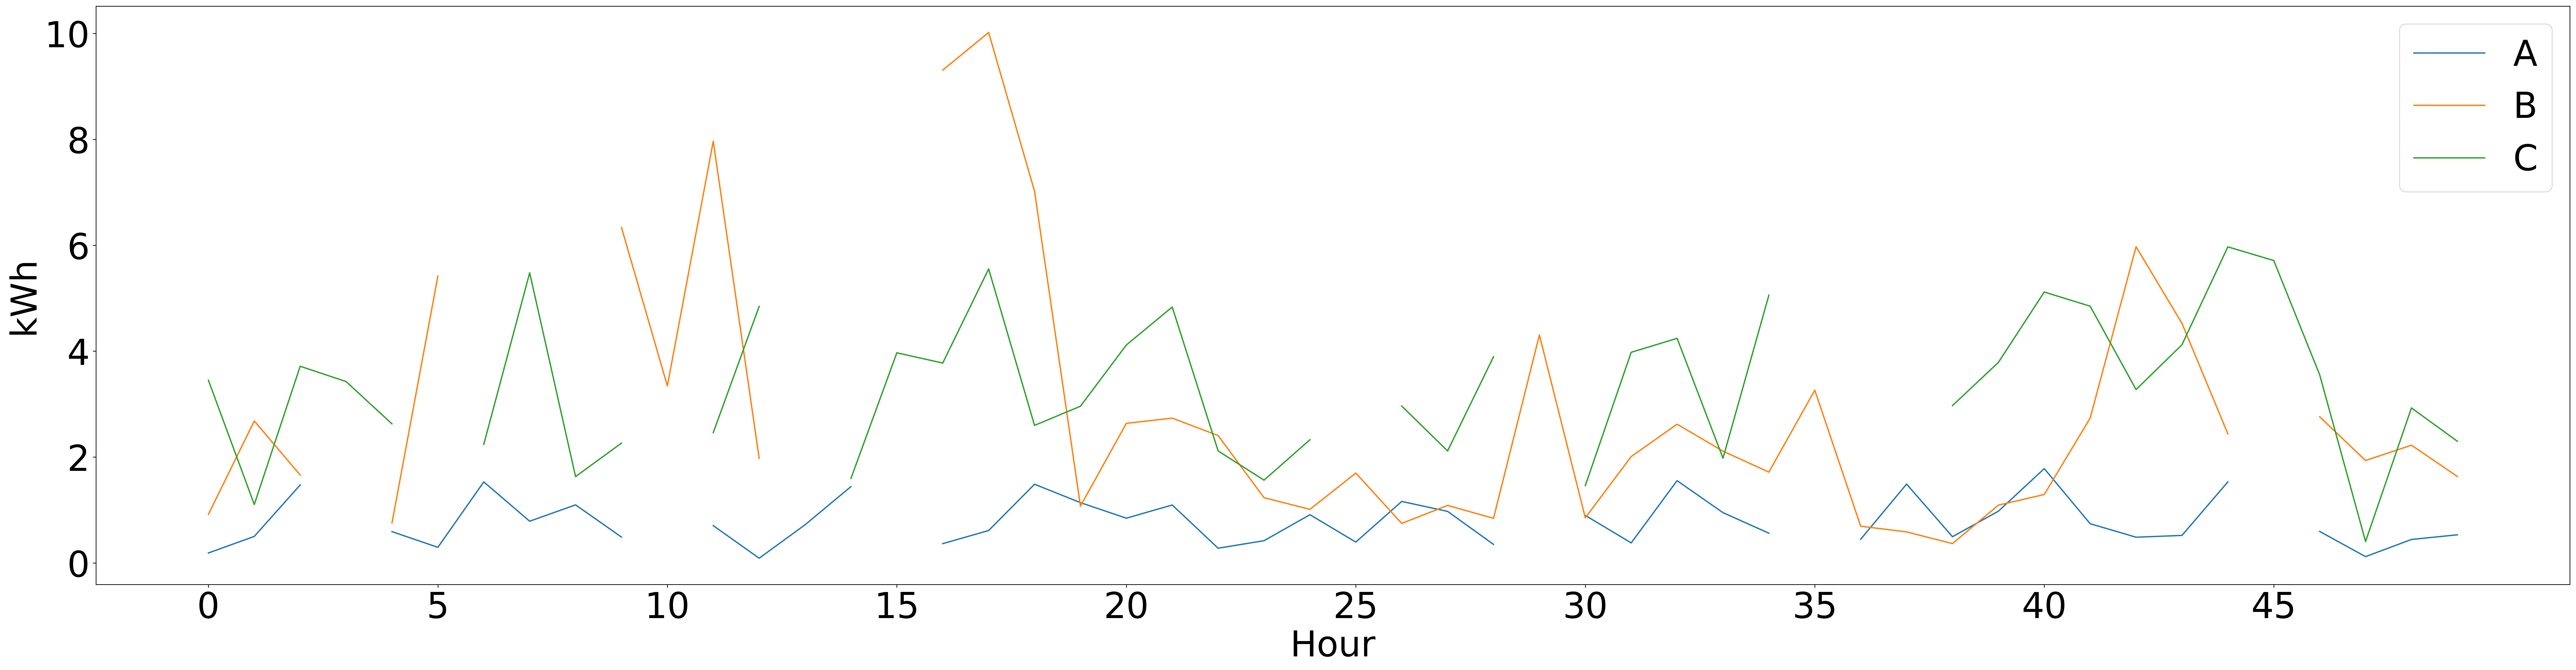

In [50]:
# plot bestLoadResponse of each LA
plt.figure(figsize=(50, 12), dpi=300)
plt.xticks(np.arange(0, numOfHours, 5), fontsize=40)
plt.yticks(np.arange(0, 15, 2), fontsize=40)
plt.xlabel('Hour', fontsize=40)
plt.ylabel('kWh', fontsize=40)
for i in range(numOfLA):
	plt.plot(LAs[i].bestLoadResponse)
plt.legend([chr(ord('A') + i) for i in range(numOfLA)], fontsize=40)
plt.show()